In [ ]:
#thrid

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing import image

C:\Users\vinod\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\vinod\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
train_data_dir = 'train'
valid_data_dir = 'validation'


In [3]:
# Dynamically determine the number of classes based on the subdirectories in the training directory
class_names = os.listdir(train_data_dir)
num_classes = len(class_names)

In [4]:
# Count the number of images in each class
num_images_per_class = {}
for class_name in class_names:
    class_path = os.path.join(train_data_dir, class_name)
    num_images = len(os.listdir(class_path))
    num_images_per_class[class_name] = num_images


In [5]:
# Dynamically determine the image size from the first image in the training dataset
sample_image_path = os.path.join(train_data_dir, class_names[0], os.listdir(os.path.join(train_data_dir, class_names[0]))[0])
sample_image = tf.keras.preprocessing.image.load_img(sample_image_path)
img_width, img_height = sample_image.size


In [6]:
# Print the number of images in each class
print("Number of images per class:")
for class_name, num_images in num_images_per_class.items():
    print(f"{class_name}: {num_images} images")


Number of images per class:
Bacterial blight: 628 images
Blast: 648 images
Brownspot: 628 images
Healthy: 314 images
Tungro: 628 images


In [7]:
# Data preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [8]:
valid_datagen = ImageDataGenerator(rescale=1.0/255)


In [9]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)


Found 2846 images belonging to 5 classes.


In [10]:
valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)


Found 180 images belonging to 5 classes.


In [11]:
# Create InceptionV3 model for transfer learning
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)


In [12]:
model = Model(inputs=base_model.input, outputs=predictions)



In [13]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False



In [14]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [16]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // 32,
    epochs=10
)


Epoch 1/10
88/88 [==============================] - 332s 4s/step - loss: 0.2222 - accuracy: 0.9250 - val_loss: 0.1876 - val_accuracy: 0.9375
Epoch 2/10
88/88 [==============================] - 313s 4s/step - loss: 0.1693 - accuracy: 0.9481 - val_loss: 0.1235 - val_accuracy: 0.9750
Epoch 3/10
88/88 [==============================] - 319s 4s/step - loss: 0.1558 - accuracy: 0.9520 - val_loss: 0.1172 - val_accuracy: 0.9688
Epoch 4/10
88/88 [==============================] - 305s 3s/step - loss: 0.1169 - accuracy: 0.9648 - val_loss: 0.1045 - val_accuracy: 0.9688
Epoch 5/10
88/88 [==============================] - 317s 4s/step - loss: 0.1065 - accuracy: 0.9687 - val_loss: 0.0994 - val_accuracy: 0.9625
Epoch 6/10
88/88 [==============================] - 311s 4s/step - loss: 0.1055 - accuracy: 0.9655 - val_loss: 0.0757 - val_accuracy: 0.9812
Epoch 7/10
88/88 [==============================] - 306s 3s/step - loss: 0.0836 - accuracy: 0.9787 - val_loss: 0.0652 - val_accuracy: 0.9875
Epoch 8/10
88

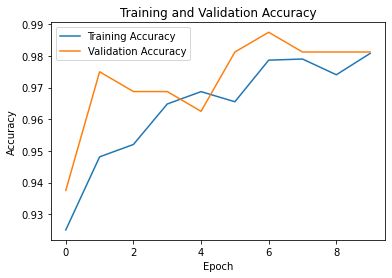

In [17]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

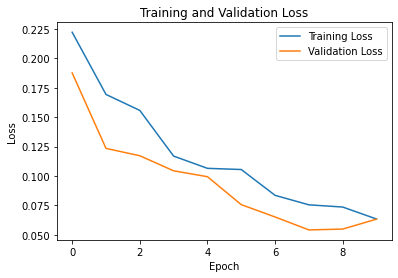

In [18]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:

# Confusion Matrix
y_true = valid_generator.classes
y_pred = model.predict(valid_generator)
y_pred_classes = np.argmax(y_pred, axis=1)


6/6 [==============================] - 15s 2s/step


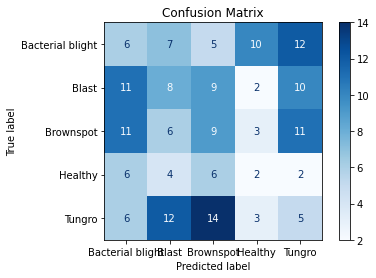

In [20]:
cm = confusion_matrix(y_true, y_pred_classes, labels=range(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format=".4g")
plt.title("Confusion Matrix")
plt.show()

In [22]:
# Save the trained model
model.save('model_path')

INFO:tensorflow:Assets written to: model_path\assets


INFO:tensorflow:Assets written to: model_path\assets


In [23]:
# Save the trained model
model.save('model_path')


INFO:tensorflow:Assets written to: model_path\assets


INFO:tensorflow:Assets written to: model_path\assets


In [24]:
# Load the trained model
loaded_model = tf.keras.models.load_model('model_path')

In [26]:
# Load and preprocess the new rice leaf image
image_path = 'test_img.jpg'  # Replace with the path to your new image
img = image.load_img(image_path, target_size=(img_width, img_height))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image


In [27]:
# Make predictions using the loaded model
predictions = loaded_model.predict(img_array)


1/1 [==============================] - 1s 1s/step


In [28]:
# Interpret the predictions
class_labels = train_generator.class_indices  # Get class labels from the training generator
predicted_class = list(class_labels.keys())[np.argmax(predictions)]


In [29]:
# Print the predicted class
print("Predicted Class:", predicted_class)


Predicted Class: Blast
